Getting started with Task 3
Download the dataset from the Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals using the script download_intracardiac_dataset.sh:

source download_intracardiac_dataset.sh
Load Modules and Preprocessing Functions
Load modules and preprocessing functions.

In [97]:
from google.colab import drive
drive.mount('/content/drive/')
# setting data folder
data_folder = './yourpath/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [98]:
ls drive/MyDrive/data_task3/

data_hearts_dd_0p2/                      data_hearts_dd_0p2_geo_inn_act_1_bcl/
data_hearts_dd_0p2_geo_act_1_bcl/        data_hearts_dd_0p2_geo_inn_act_1_bcl_I/
data_hearts_dd_0p2_geo_act_1_bcl_gkr/    data_hearts_dd_0p2_geo_inn_act_2_bcl/
data_hearts_dd_0p2_geo_act_1_bcl_gkr_I/  data_hearts_dd_0p2_geo_inn_act_2_bcl_I/
data_hearts_dd_0p2_geo_act_2_bcl/        data_hearts_dd_0p2_geo_inn_act_3_bcl/
data_hearts_dd_0p2_geo_act_2_bcl_gkr/    data_hearts_dd_0p2_geo_inn_act_3_bcl_I/
data_hearts_dd_0p2_geo_act_2_bcl_gkr_I/  documentation/
data_hearts_dd_0p2_geo_act_3_bcl/        figures/
data_hearts_dd_0p2_geo_act_3_bcl_gkr/    intracardiac_dataset/
data_hearts_dd_0p2_geo_act_3_bcl_gkr_I/  license/
data_hearts_dd_0p2_geo_inn/              notebooks/


In [99]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [100]:
def read_data_dirs(
        dirs_names : List[str] = ['../intracardiac_dataset/data_hearts_dd_0p2/'],
        verbose : int = 0) -> List[List[str]]:
    """
    Read the numpy files in the given directories.
    Returns a list of file pairs ECG/Vm.

    Parameters
    ----------
    dirs_names : List[str]
        List of directories containing the data.
    verbose : int
        Verbosity level.

    Returns
    -------
    file_pairs : List[List[str]]
        List of file pairs.
    """
    file_pairs = []

    for dir in dirs_names:
        all_files = sorted(glob.glob(dir + '/*.npy'))
        files_Vm=[]
        files_pECG=[]

        if verbose > 0:
            print('Reading files...',end='')
        for file in all_files:
            if 'VmData' in file:
                files_Vm.append(file)
            if 'pECGData' in file:
                files_pECG.append(file)
        if verbose > 0:
            print(' done.')

        if verbose > 0:
            print('len(files_pECG) : {}'.format(len(files_pECG)))
            print('len(files_Vm) : {}'.format(len(files_Vm)))

        for i in range(len(files_pECG)):
            VmName =  files_Vm[i]
            VmName = VmName.replace('VmData', '')
            pECGName =  files_pECG[i]
            pECGName = pECGName.replace('pECGData', '')
            if pECGName == VmName :
                file_pairs.append([files_pECG[i], files_Vm[i]])
            else:
                print('Automatic sorted not matching, looking for pairs ...',end='')
                for j in range(len(files_Vm)):
                    VmName =  files_Vm[j]
                    VmName = VmName.replace('VmData', '')
                    if pECGName == VmName :
                        file_pairs.append([files_pECG[i], files_Vm[j]])
                print('done.')
    return file_pairs

In [101]:
def get_standard_leads(
        pECGnumpy : np.ndarray
    ) -> np.ndarray :
    """
    Get the standard 12-lead from the 10-lead ECG.

    Parameters
    ----------
    pECGnumpy : np.ndarray
        10-lead ECG.

    Returns
    -------
    ecg12aux : np.ndarray
        12-lead ECG.
    """
    # pECGnumpy  : RA LA LL RL V1 V2 V3 V4 V5 V6
    # ecg12aux : i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5, v6
    ecg12aux = np.zeros((pECGnumpy.shape[0],12))
    WilsonLead = 0.33333333 * (pECGnumpy[:,0] + pECGnumpy[:,1] + pECGnumpy[:,2])
    # Lead I: LA - RA
    ecg12aux[:,0] = pECGnumpy[:,1] - pECGnumpy[:,0]
    # Lead II: LL - RA
    ecg12aux[:,1] = pECGnumpy[:,2] - pECGnumpy[:,0]
    # Lead III: LL - LA
    ecg12aux[:,2] = pECGnumpy[:,2] - pECGnumpy[:,1]
    # Lead aVR: 3/2 (RA - Vw)
    ecg12aux[:,3] = 1.5*(pECGnumpy[:,0] - WilsonLead)
    # Lead aVL: 3/2 (LA - Vw)
    ecg12aux[:,4] = 1.5*(pECGnumpy[:,1] - WilsonLead)
    # Lead aVF: 3/2 (LL - Vw)
    ecg12aux[:,5] = 1.5*(pECGnumpy[:,2] - WilsonLead)
    # Lead V1: V1 - Vw
    ecg12aux[:,6] = pECGnumpy[:,4] - WilsonLead
    # Lead V2: V2 - Vw
    ecg12aux[:,7] = pECGnumpy[:,5] - WilsonLead
    # Lead V3: V3 - Vw
    ecg12aux[:,8] = pECGnumpy[:,6] - WilsonLead
    # Lead V4: V4 - Vw
    ecg12aux[:,9] = pECGnumpy[:,7] - WilsonLead
    # Lead V5: V5 - Vw
    ecg12aux[:,10] = pECGnumpy[:,8] - WilsonLead
    # Lead V6: V6 - Vw
    ecg12aux[:,11] = pECGnumpy[:,9] - WilsonLead

    return ecg12aux

In [102]:
def get_activation_time(
        Vm : np.ndarray
    ) -> np.ndarray :
    """
    Get the activation time from the Vm.

    Parameters
    ----------
    Vm : np.ndarray
        Vm.

    Returns
    -------
    actTime : np.ndarray
        Activation time.
    """
    actTime = []
    # check that Vm has 75 columns
    if Vm.shape[1] != 75:
        print('Error: Vm does not have 75 columns')
        return actTime
    for col in range(0,75,1):
        actTime.append(np.argmax(Vm[:,col]>0))
    actTime = np.asarray(actTime)
    actTime = np.reshape(actTime,(75,1))
    return actTime

In [103]:
#randy = np.random.rand(500,75)
#slack = get_activation_time(randy)
#VmData = np.load(read_data_dirs())
#slack = get_activation_time(VmData)
#slack.shape
#slack

In [104]:
standard_leads = get_standard_leads(np.load(file_pairs[case][0]))
standard_leads.shape
#standard_leads

(500, 12)

In [105]:
#%run cardiac_ml_tools.py

In [106]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='drive/MyDrive/data_task3/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))

Number of file pairs: 16117
Example of file pair:
drive/MyDrive/data_task3/data_hearts_dd_0p2_geo_inn_act_3_bcl/pECGData_hearts_dd_0p2_geo_inn_act_3_bcl_bcl.1000.innerindex.0.volunteer.v13.npy
drive/MyDrive/data_task3/data_hearts_dd_0p2_geo_inn_act_3_bcl/VmData_hearts_dd_0p2_geo_inn_act_3_bcl_bcl.1000.innerindex.0.volunteer.v13.npy


Case 213 : drive/MyDrive/data_task3/data_hearts_dd_0p2_geo_inn_act_3_bcl/pECGData_hearts_dd_0p2_geo_inn_act_3_bcl_bcl.1000.innerindex.74.volunteer.v14.npy


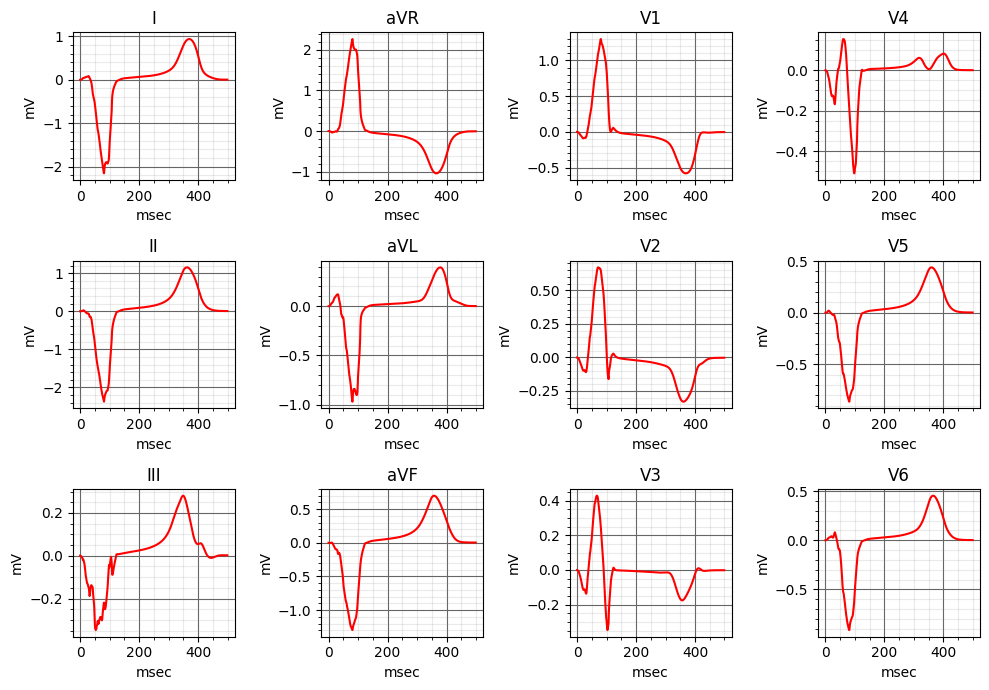

In [107]:
# Example of file pair
case = 213
# ECG plot
row = 3
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

# create a figure with 12 subplots
for i in range(pECGData.shape[1]):
    plt.subplot(row, column, reorder[i + 1])
    plt.plot(pECGData[0:num_timesteps,i],'r')
    plt.title(titles[i])
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

In [108]:
#ActTime.shape

Case 213 : drive/MyDrive/data_task3/data_hearts_dd_0p2_geo_inn_act_3_bcl/pECGData_hearts_dd_0p2_geo_inn_act_3_bcl_bcl.1000.innerindex.74.volunteer.v14.npy


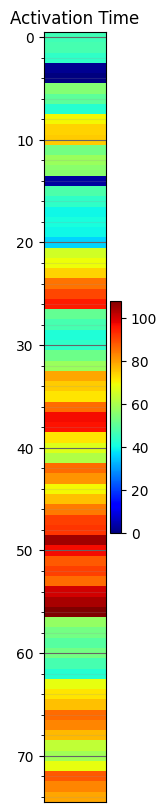

In [109]:
# Example of file pair
case = 213
plt.figure(figsize=(1, 10))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

ActTime = get_activation_time(VmData)

# plot the Activation Time array
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('Activation Time')
plt.colorbar()
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
# not xticks
plt.xticks([])
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

Case 213 : drive/MyDrive/data_task3/data_hearts_dd_0p2_geo_inn_act_3_bcl/pECGData_hearts_dd_0p2_geo_inn_act_3_bcl_bcl.1000.innerindex.74.volunteer.v14.npy
Case 213 : drive/MyDrive/data_task3/data_hearts_dd_0p2_geo_inn_act_3_bcl/pECGData_hearts_dd_0p2_geo_inn_act_3_bcl_bcl.1000.innerindex.74.volunteer.v14.npy


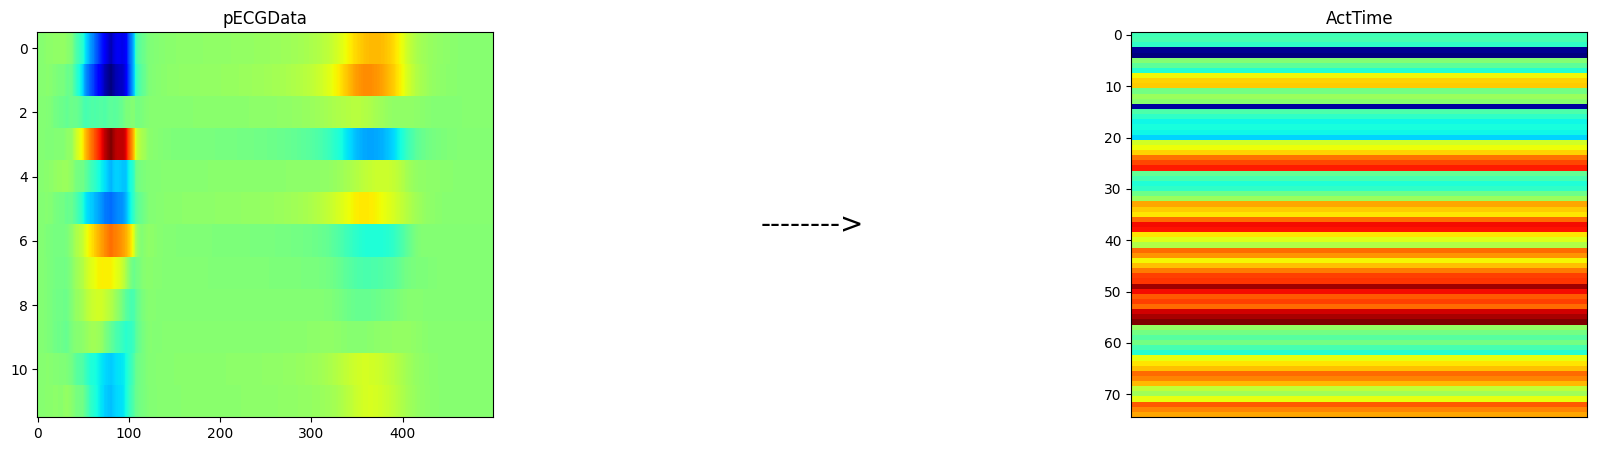

In [110]:
# make a plot with the "pECGData" -> "ActTime"
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])
ActTime = get_activation_time(VmData)

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print an arrow
plt.text(0.5, 0.5, '-------->', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.axis('off')
plt.subplot(row, column, 3)
# plot ActTime
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
# not xticks
plt.xticks([])
plt.title('ActTime')
plt.show()
plt.close()

Case 213 : drive/MyDrive/data_task3/data_hearts_dd_0p2_geo_inn_act_3_bcl/pECGData_hearts_dd_0p2_geo_inn_act_3_bcl_bcl.1000.innerindex.74.volunteer.v14.npy


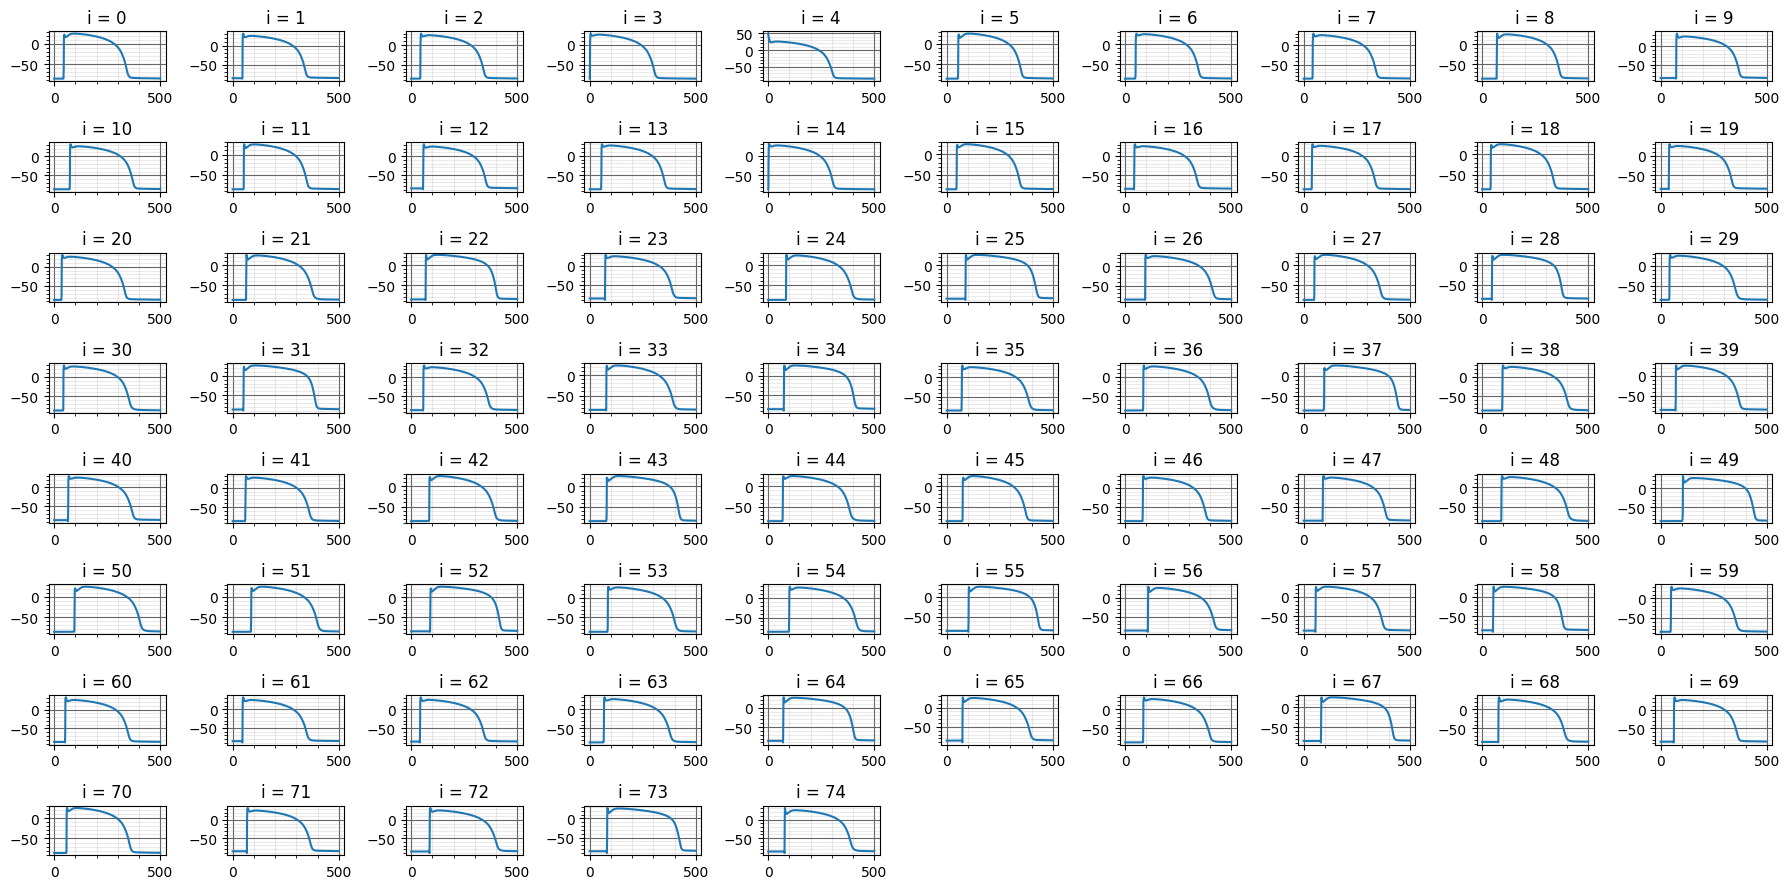

In [111]:
# Example of file pair
case = 213
# Vm plot
row = 7
column = 10
plt.figure(figsize=(18, 9))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

In [112]:
import numpy as np
import pandas as pd

# Assuming pECGData is loaded as a 2D NumPy array with shape (num_samples, num_time_steps)
# For example, pECGData = np.load('your_pECG_data_file.npy')

# Example shape: (num_samples, 500) for pECGData
# Let's assume pECGData has shape (500, 12), where 500 is time steps and 12 is features
# pECGData needs to be transposed if it's not already in (time_steps, features)

# Transpose pECGData if needed
# pECGData = pECGData.T  # Shape should now be (time_steps, features)

# Prepare pECGData
num_time_steps = pECGData.shape[0]  # e.g., 500
num_features = pECGData.shape[1]     # e.g., 12

# Reshape to (samples, time_steps, features)
# Let's assume you want to use the entire dataset as a single sample for demonstration purposes
X = pECGData.reshape(1, num_time_steps, num_features)

# Prepare actTime, which should be a 1D array of targets corresponding to the input data
# Ensure actTime is a NumPy array
# Example: actTime = np.array([1, 0, 1])  # Replace with your actual actTime values
# actTime = actTime.reshape(1, -1)  # Reshape if necessary


In [113]:
pECGData.shape

(500, 12)

In [114]:
num_samples, num_time_steps, num_features

(10, 500, 12)

In [115]:
# Install necessary packages
!pip install keras-tcn  # Install TCN package

# Import required libraries
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense
from tcn import TCN  # Import TCN layer

# Sample Data Preparation (replace this with your actual data)
# Assuming pECGData and actTime are already defined.
# For example, let's create some mock data:
num_time_steps = 500  # Example number of time steps
num_features = 12      # Example number of features
num_samples = 10       # Example number of samples for training

# Mock input data (e.g., pECGData)
pECGData = np.random.rand(num_samples, num_time_steps, num_features)  # Shape: (10, 500, 12)

# Mock target data (e.g., actTime)
actTime = np.random.rand(num_samples, 75)  # Shape: (10, 75) for regression task

# Define the TCN model
model = Sequential()

# Input layer
model.add(Input(shape=(num_time_steps, num_features)))

# Add TCN layer
model.add(TCN(32, kernel_size=3, dilations=[1, 2, 4, 8], activation='relu'))

# Add a Dense layer for output (ensure the output shape matches actTime)
model.add(Dense(75))  # Ensure this matches the shape of actTime

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Use appropriate loss function

# Print the model summary
model.summary()

# Train the model (using mock data here)
model.fit(pECGData, actTime, epochs=50, batch_size=1)  # Adjust epochs and batch si

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_2 (TCN)                 (None, 32)                23328     
                                                                 
 dense_2 (Dense)             (None, 75)                2475      
                                                                 
Total params: 25803 (100.79 KB)
Trainable params: 25803 (100.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 3s 10ms/step - loss: 4.0774
Epoch 2/50
10/10 [==============================] - 0s 10ms/step - loss: 0.7321
Epoch 3/50
10/10 [==============================] - 0s 8ms/step - loss: 0.4396
Epoch 4/50
10/10 [==============================] - 0s 8ms/step - loss: 0.3449
Epoch 5/50
10/10 [==============================] - 0s 8ms/step - loss: 0.2899
Epoch 6/50
10/

In [116]:
# Define the TCN model
model = Sequential()

# Input layer
model.add(Input(shape=(num_time_steps, num_features)))

# Add TCN layer
model.add(TCN(32, kernel_size=3, dilations=[1, 2, 4, 8], activation='relu'))

# Reshape output to match (None, num_time_steps, 75)
# Since you want an output of (500, 75), you can use TimeDistributed Dense layer
model.add(Dense(75))  # Output shape of (None, 500, 75)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

# Train the model (using mock data here)
model.fit(pECGData, actTime, epochs=50, batch_size=1)


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_3 (TCN)                 (None, 32)                23328     
                                                                 
 dense_3 (Dense)             (None, 75)                2475      
                                                                 
Total params: 25803 (100.79 KB)
Trainable params: 25803 (100.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 5s 11ms/step - loss: 1.9032
Epoch 2/50
10/10 [==============================] - 0s 17ms/step - loss: 0.5252
Epoch 3/50
10/10 [==============================] - 0s 15ms/step - loss: 0.3293
Epoch 4/50
10/10 [==============================] - 0s 22ms/step - loss: 0.2582
Epoch 5/50
10/10 [==============================] - 0s 15ms/step - loss: 0.2193
Epoch 6/50


In [117]:
# Training Loop
epochs = 50  # Number of epochs
for epoch in range(epochs):
    # model.train()  # Set the model to training mode
    running_loss = 0.0

    for batch_data, batch_targets in data_loader:
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(batch_data)

        # Remove the extra dimension from outputs
        outputs = outputs[:, -1, :]

        loss = criterion(outputs, batch_targets)  # Calculate the loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()  # Accumulate loss

    # Print the average loss for the epoch
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(data_loader):.4f}')

# After training, you can evaluate or make predictions with the model

NameError: name 'data_loader' is not defined

In [ ]:
model.eval()

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

  Probably do not need

In [ ]:
# Install necessary packages
!pip install pytorch-forecasting
!pip install pytorch-tcn
from pytorch_tcn import TCN
# from TCN.tcn import TemporalConvNet
# from tcn import TemporalConvNet
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tcn # Using TCN package for PyTorch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_forecasting import TemporalFusionTransformer  # Just an example; adapt as needed
#from pytorch_forecasting.models import TCN

# Sample Data Preparation (replace this with your actual data)
# Assuming pECGData and actTime are already defined.
num_time_steps = 500  # Example number of time steps
num_features = 12      # Example number of features
num_samples = 10       # Example number of samples for training

# Mock input data (e.g., pECGData)
pECGData = np.random.rand(num_samples, num_time_steps, num_features).astype(np.float32)  # Shape: (10, 500, 12)
pECGData = torch.tensor(pECGData)  # Convert to PyTorch tensor

# Mock target data (e.g., actTime)
actTime = np.random.rand(num_samples, 75).astype(np.float32)  # Shape: (10, 75) for regression task
actTime = torch.tensor(actTime)  # Convert to PyTorch tensor

# Define the TCN model
class TCNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(TCNModel, self).__init__()
        # Define TCN layer
        self.tcn = TemporalConvNet(input_size, num_blocks=1, num_channels=[32], kernel_size=3, dropout=0.0)
        # Fully connected layer
        self.fc = nn.Linear(num_time_steps, output_size)

    def forward(self, x):
        # Pass through TCN layer
        x = self.tcn(x)
        # Rearrange for dense layer
        x = x[:, :, -1]  # Take the last time step output
        x = self.fc(x)
        return x

# Instantiate the model
model = TCNModel(num_features, 75)  # Output size is 75
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
batch_size = 1  # Note: Adjust as needed
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(pECGData)
    loss = criterion(outputs, actTime)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
# Assuming you've trained your model and have the following variables set up
# `model` is your trained TCN model
# `pECGData` is your input data (the same shape as during training)

# Make sure to switch the model to evaluation mode
model.eval()

# Prepare your data for predictions
# Here we use the original pECGData, but in practice, you should use new data for prediction
with torch.no_grad():  # Disable gradient calculation for inference
    # Convert pECGData to a PyTorch tensor
    input_tensor = torch.from_numpy(pECGData).float()  # Convert NumPy array to tensor

    # Make predictions
    predictions = model(input_tensor)

# If you want to convert predictions back to NumPy array for further processing or visualization
predictions_np = predictions.numpy()  # Convert predictions to NumPy array

# Print the shape of predictions
print("Predictions shape:", predictions_np.shape)

# If you want to visualize or analyze predictions, you can do so here
# For example, let's print the first few predictions
print("First few predictions:", predictions_np[:5])


In [ ]:
predictions.shape

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'predictions_np' contains your model's predictions
# and 'actTime' contains the true values (flatten if necessary)
actTime_np = actTime.flatten()  # Flatten the true values if needed
predictions_np = predictions.numpy().flatten()  # Flatten predictions for easier plotting

# Plot true values vs. predictions for the first few samples
plt.figure(figsize=(12, 6))
plt.plot(actTime_np[:50], label='True Values', marker='o', color='blue')  # First 50 true values
plt.plot(predictions_np[:50], label='Predictions', marker='x', color='orange')  # First 50 predictions
plt.title('True Values vs Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


7/30/24

In [118]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os

class CustomDataset(Dataset):
    def __init__(self, data_dir, label_file):
        self.data_dir = data_dir
        self.labels = np.load(label_file)
        self.file_names = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy')])

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        x = np.load(os.path.join(self.data_dir, self.file_names[idx]))
        y = self.labels[idx]
        return torch.from_numpy(x).float(), torch.from_numpy(y).float()

def get_dataloader(data_dir, label_file, batch_size, shuffle=True, num_workers=0):
    dataset = CustomDataset(data_dir, label_file)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Example usage:
data_dir = 'path_to_data_directory'
label_file = 'path_to_labels.npy'
batch_size = 32

train_loader = get_dataloader(data_dir, label_file, batch_size)

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_labels.npy'

In [119]:
# %% [code]
""" A very simple Temporal Convolutional Networks baseline
* TCN implementation is adapted from https://github.com/locuslab/TCN
* This is a very small dataset, so it's very easy to overfit. Tune carefully.
* Check the "Output" tab for training logs.
"""
from subprocess import call
import os

FNULL = open(os.devnull, 'w')
call("pip install https://github.com/ceshine/pytorch_helper_bot/archive/0.0.3.zip".split(" "), stdout=FNULL, stderr=FNULL)

# set SEED
os.environ["SEED"] = "42"

DEVICE = "cpu"

# ======================
#     TCN Components
# ======================
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = weight_norm(nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout,
                                 self.pad, self.conv2, self.relu, self.dropout)
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x.unsqueeze(2)).squeeze(2)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# ======================
#     Dataset Utils
# ======================
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset


def get_dataset(x, y):
    return TensorDataset(
        torch.from_numpy(x).float(),
        torch.from_numpy(y).float()
    )


def get_dataloader(x: np.array, y: np.array, batch_size: int, shuffle: bool = True, num_workers: int = 0):
    dataset = get_dataset(x, y)
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
    )


def get_ndarray(embedding_values):
    results = []
    for row in embedding_values:
        arr = np.array(row)
        results.append(
            np.pad(arr, ((10 - arr.shape[0], 0), (0, 0)), 'constant')
        )
    # shape: (examples, emb_dim, seq_length)
    return np.transpose(np.stack(results), (0, 2, 1))


def read_dataset(data_dir=Path("data/")):
    if isinstance(data_dir, str):
        data_dir = Path(data_dir)
    df_train = pd.read_json(data_dir / 'train.json')
    df_test = pd.read_json(data_dir / 'test.json')
    x_train = get_ndarray(df_train.audio_embedding)
    y_train = df_train.is_turkey.values
    x_test = get_ndarray(df_test.audio_embedding)
    test_id = df_test.vid_id
    return x_train, y_train, x_test, test_id


# ===============================================
#     Model Creation, Training, and Inference
# ==============================================
import logging

from helperbot.bot import BaseBot
from helperbot.lr_scheduler import TriangularLR
from helperbot.weight_decay import WeightDecayOptimizerWrapper
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
import torch.nn as nn
import pandas as pd

class TurkeyBot(BaseBot):
    name = "Turkey"

    def __init__(self, model, train_loader, val_loader, *, optimizer,
                 avg_window=20, log_dir="./cache/logs/",
                 log_level=logging.INFO, checkpoint_dir="./cache/model_cache/"):
        super().__init__(
            model, train_loader, val_loader,
            optimizer=optimizer, avg_window=avg_window,
            log_dir=log_dir, log_level=log_level, checkpoint_dir=checkpoint_dir,
            batch_idx=0, echo=False, device=DEVICE
        )
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.loss_format = "%.8f"


class TCNModel(nn.Module):
    def __init__(self, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(
            128, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.decoder = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        return self.decoder(self.dropout(self.tcn(x)[:, :, -1]))


def main():
    x_train, y_train, x_test, test_id = read_dataset("../input/")

    test_loader = get_dataloader(
        x_test, np.zeros(x_test.shape[0]), batch_size=128, shuffle=False)

    test_pred_list, val_losses = [], []
    kf = StratifiedKFold(n_splits=8, random_state=31829, shuffle=True)
    for train_index, valid_index in kf.split(x_train, y_train):
        train_loader = get_dataloader(
            x_train[train_index], y_train[train_index],
            batch_size=32, shuffle=True
        )
        val_loader = get_dataloader(
            x_train[valid_index], y_train[valid_index],
            batch_size=128, shuffle=False
        )

        model = TCNModel(num_channels=[20] * 2, kernel_size=3, dropout=0.25)
        model.to(DEVICE)
        optimizer = torch.optim.Adam(
            model.parameters(), betas=(0.9, 0.999), lr=1e-3, weight_decay=0)
        # optimizer = WeightDecayOptimizerWrapper(
        #     optimizer, weight_decay=5e-3
        # )
        batches_per_epoch = len(train_loader)
        bot = TurkeyBot(
            model, train_loader, val_loader,
            optimizer=optimizer, avg_window=batches_per_epoch
        )
        n_steps = batches_per_epoch * 20
        scheduler = TriangularLR(
            optimizer, max_mul=8, ratio=9,
            steps_per_cycle=n_steps
        )
        bot.train(
            n_steps,
            log_interval=batches_per_epoch // 2,
            snapshot_interval=batches_per_epoch,
            early_stopping_cnt=10, scheduler=scheduler)
        val_preds = torch.sigmoid(bot.predict_avg(
            val_loader, k=3, is_test=True).cpu()).numpy().clip(1e-5, 1-1e-5)
        loss = log_loss(y_train[valid_index], val_preds)
        if loss > 0.2:
            # Ditch folds that perform terribly
            bot.remove_checkpoints(keep=0)
            continue
        print("AUC: %.6f" % roc_auc_score(y_train[valid_index], val_preds))
        print("Val loss: %.6f" % loss)
        val_losses.append(loss)
        test_pred_list.append(torch.sigmoid(bot.predict_avg(
            test_loader, k=3, is_test=True).cpu()).numpy().clip(1e-5, 1-1e-5))
        bot.remove_checkpoints(keep=0)

    val_loss = np.mean(val_losses)
    test_preds = np.mean(test_pred_list, axis=0)
    print("Validation losses: %.6f +- %.6f" %
          (np.mean(val_losses), np.std(val_losses)))

    df_sub = pd.DataFrame({
        "vid_id": test_id,
        "is_turkey": test_preds
    })
    df_sub.to_csv("submission.csv", index=False)

main()

FileNotFoundError: File ../input/train.json does not exist

In [120]:
import numpy as np

# Initialize an empty list to hold the concatenated results
# result = np.empty((100, 500, 12))  # Replace (0, 12) with the expected shape of pECGData
result = []

for i in range(100):  # This will iterate from 0 to 99
    pECGData = np.load(file_pairs[i][0])  # Load your data
    pECGData = get_standard_leads(pECGData)  # Transform your data

    # # Concatenate the new pECGData to the result
    # result = np.concatenate((result, pECGData), axis=0)  # Concatenate along the first axis
    result.append(pECGData)

# Convert the list to a NumPy array
result = np.array(result)
print(result.shape)

(100, 500, 12)


In [121]:
pECGData.shape

(500, 12)

In [122]:
result.shape

(100, 500, 12)

In [123]:
output = []
for i in range(100):
  VmData = np.load(file_pairs[i][1])
  ActTime = get_activation_time(VmData)
  #output = np.concatenate((output, ActTime), axis=0)
  output.append(ActTime)

output = np.array(output)
print(output.shape)

(100, 75, 1)


In [124]:
output.shape

(100, 75, 1)

In [125]:
result.shape, output.shape

((100, 500, 12), (100, 75, 1))

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(result, output, test_size=0.2)

In [127]:
import tensorflow.keras.backend as K

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

In [128]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, AveragePooling1D

In [129]:
class FireLayer(tf.keras.layers.Layer):
    def __init__(self, squeeze_filters, expand_filters, **kwargs):
        super(FireLayer, self).__init__(**kwargs)
        self.squeeze = Conv1D(squeeze_filters, 1, activation='relu', padding='valid')
        self.expand1x1 = Conv1D(expand_filters, 1, activation='relu', padding='valid')
        self.expand3x3 = Conv1D(expand_filters, 3, activation='relu', padding='same')

    def call(self, inputs):
        x = self.squeeze(inputs)
        output = tf.concat([self.expand1x1(x), self.expand3x3(x)], axis=-1)
        return output

In [133]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense

model = Sequential()

# Initial Conv1D layer
model.add(Conv1D(64, 3, activation='relu', strides=1, padding='same', input_shape=(500, 12)))

# Fire layers
model.add(FireLayer(16, 64))
model.add(FireLayer(16, 64))

model.add(FireLayer(32, 128))
model.add(FireLayer(32, 128))

model.add(FireLayer(48, 192))
model.add(FireLayer(48, 192))

model.add(FireLayer(64, 256))
model.add(FireLayer(64, 256))

# Dropout layer
model.add(Dropout(0.1))

# Final Conv1D layer to reduce to a single feature output
# This layer needs to reduce the output to a shape compatible with (75, 1)
model.add(Conv1D(1, 3, activation='linear', padding='valid'))  # Produces shape (batch_size, 498, 1)

# Flatten the output to reduce the dimension and allow for Dense layers
model.add(Flatten())

# Fully connected layer to map to the desired output shape
model.add(Dense(75))  # Now output shape will be (batch_size, 75)

# Reshape to the final output shape (75, 1)
model.add(Reshape((75, 1)))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r_squared])
model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_297 (Conv1D)         (None, 500, 64)           2368      
                                                                 
 fire_layer_88 (FireLayer)   (None, 500, 128)          5264      
                                                                 
 fire_layer_89 (FireLayer)   (None, 500, 128)          6288      
                                                                 
 fire_layer_90 (FireLayer)   (None, 500, 256)          20768     
                                                                 
 fire_layer_91 (FireLayer)   (None, 500, 256)          24864     
                                                                 
 fire_layer_92 (FireLayer)   (None, 500, 384)          49584     
                                                                 
 fire_layer_93 (FireLayer)   (None, 500, 384)        

In [134]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
3/3 [==============================] - 9s 775ms/step - loss: 7418.5518 - r_squared: -6.2165
Epoch 2/20
3/3 [==============================] - 3s 756ms/step - loss: 7412.6670 - r_squared: -6.1597
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 7374.3779 - r_squared: -6.1030
Epoch 4/20
3/3 [==============================] - 4s 1s/step - loss: 7186.8877 - r_squared: -5.9959
Epoch 5/20
3/3 [==============================] - 3s 758ms/step - loss: 6157.2393 - r_squared: -4.9029
Epoch 6/20
3/3 [==============================] - 3s 768ms/step - loss: 2874.4302 - r_squared: -2.1323
Epoch 7/20
3/3 [==============================] - 3s 763ms/step - loss: 1618.1409 - r_squared: -0.5547
Epoch 8/20
3/3 [==============================] - 3s 787ms/step - loss: 2002.9114 - r_squared: -0.9465
Epoch 9/20
3/3 [==============================] - 4s 1s/step - loss: 1550.5996 - r_squared: -0.4507
Epoch 10/20
3/3 [==============================] - 3s 750ms/step - loss: 1214.6649

In [135]:
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 675ms/step


In [136]:
ActTime_pred.shape
ActTime_test.shape

(75, 1)

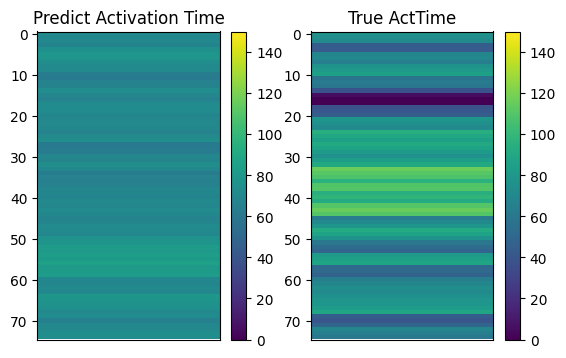

In [137]:
ActTime_pred = y_pred[0]
ActTime_test = y_test[0]

row = 1
column = 3
plt.figure(figsize=(10, 4))

plt.subplot(row, column, 1)
plt.imshow(ActTime_pred, cmap='viridis', interpolation='nearest', aspect='auto', vmin=0, vmax=150)
plt.title('Predict Activation Time')
plt.xticks([])
plt.colorbar()

plt.subplot(row, column, 2)
plt.imshow(ActTime_test, cmap='viridis', interpolation='nearest', aspect='auto', vmin=0, vmax=150)
plt.title('True ActTime')
plt.xticks([])
plt.colorbar()

plt.show()
plt.close()